We move on to the conservative form of 2D SWE. The staggered grid is much more stable, and even the Euler explicit scheme is stable on a staggered grid. Usually, the conservative form of any set of equations is found to be more stable, as it is able to handle shocks too. For the present case, the conservative equations are:

$$ \frac{\partial U}{\partial t} + \frac{(U^2/h)}{\partial x} + \frac{(UV/h)}{\partial y} - fV = - gh \frac{\partial h}{\partial x} $$

$$ \frac{\partial V}{\partial t} + \frac{(UV/h)}{\partial x} + \frac{(V^2/h)}{\partial y} + fU = - gh \frac{\partial h}{\partial y} $$

$$ \frac{\partial h}{\partial t} + \frac{\partial U}{\partial x} + \frac{\partial V}{\partial y} = 0 $$

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from matplotlib import animation
from mpl_toolkits import mplot3d

In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import Euler.Periodic_2D as elr

## Euler explicit scheme and unstaggered grid

In [3]:
#Defining constants

g = 9.81
r0 = 6.378*10**6
day = 24*60*60
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))

In [4]:
Lx, Ly = 6, 6
nx, ny = 100, 100
dx, dy = Lx/nx, Ly/ny

x = np.linspace(-Lx/2, Lx/2, nx+1, dtype = float)
y = np.linspace(-Ly/2, Ly/2, ny+1, dtype = float)
X, Y = np.meshgrid(x, y)

In [5]:
# Boundary conditions

def periodic_BC(u, v, h):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]
    
    v[:, 0] = v[:, -2]
    v[:, -1] = v[:, 1]
    v[0, :] = v[-2, :]
    v[-1, :] = v[1, :]
    
    h[0, :] = h[-2, :]
    h[-1, :] = h[1, :]
    h[:, 0] = h[:, -2]
    h[:, -1] = h[:, 1]
    
    return (u, v, h)

In [6]:
U_old = np.zeros((nx+1, ny+1))
U_new = np.zeros((nx+1, ny+1))

V_old = np.zeros((nx+1, ny+1))
V_new = np.zeros((nx+1, ny+1))

h_old = 1 + 0.01*np.exp(-10*(X**2 + Y**2))
h_new = np.zeros((nx+1, ny+1))

t_start = 0
t_end = 10
dt = 0.01
count = 0

# Needed to create animations
U_data = np.zeros(((nx+1, ny+1, int(t_end/dt) + 1)))
V_data = np.zeros(((nx+1, ny+1, int(t_end/dt) + 1)))
h_data = np.zeros(((nx+1, ny+1, int(t_end/dt) + 1)))

for t in np.arange(t_start,t_end,dt):
    
    # Governing equations for interior points
    U_new[1:nx, 1:ny] = U_old[1:nx, 1:ny] - dt*elr.partial_x_cd(U_old**2/h_old, dx, nx)[1:nx, 1:ny] - dt*elr.partial_y_cd(
        U_old*V_old/h_old, dy, nx)[1:nx, 1:ny] + dt*f*V_old[1:nx, 1:ny] - 0.5*dt*g*elr.partial_x_cd(h_old**2, dx, nx)[1:nx, 1:ny]
    V_new[1:nx, 1:nx] = V_old[1:nx, 1:ny] - dt*elr.partial_x_cd(U_old*V_old/h_old, dx, nx)[1:nx, 1:ny] - dt*elr.partial_y_cd(
        V_old**2/h_old, dy, ny)[1:nx, 1:ny] - dt*f*U_old[1:nx, 1:ny] - 0.5*dt*g*elr.partial_y_cd(h_old**2, dy, ny)[1:nx, 1:ny]
    h_new[1:nx, 1:ny] = h_old[1:nx, 1:ny] - dt*elr.partial_x_cd(U_old, dx, nx)[1:nx, 1:ny] - dt*elr.partial_y_cd(V_old, dy, ny)[1:nx, 1:ny]
    
    periodic_BC(U_new, V_new, h_new)
    
    U_data[:, :, count] = U_new
    V_data[:, :, count] = V_new
    h_data[:, :, count] = h_new
    
    h_old = h_new
    U_old = U_new
    V_old = V_new
    
    count = count + 1

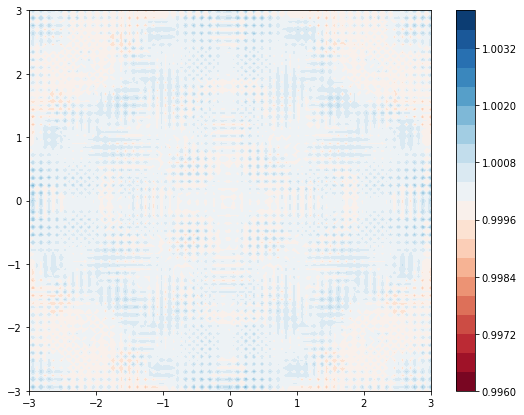

In [7]:
plt.figure(figsize = (9, 7))
plt.contourf(X, Y, h_new, levels = np.linspace(0.996, 1.004, 21), cmap = 'RdBu')
plt.colorbar()

In [8]:
fig,ax = plt.subplots(figsize = (9,7))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i*10))
    p1 = plt.contourf(X, Y, h_data[:,:,i*10], levels = np.linspace(0.998, 1.002, 21), cmap = 'RdBu')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = int(t_end/dt/10)
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/Unst_EE_Cons_hm.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/Unst_EE_Cons_hm.mp4')

The Euler explicit case works okay for the unstaggered grid, as long as it hasn't reached the boundaries. After that, spurious oscillations start to occur, and the animation shows these checkerboard patterns. These patterns are a classical problem in fluid mechanics, and is most easily resolved by using a staggered grid. 

## Euler explicit scheme and staggered grid

We use the following 2D staggered grid:

     ----V---- ----V---- ----V----
    |    |    |    |    |    |    |
    U----h----U----h----U----h----U
    |    |    |    |    |    |    |
     ----V---- ----V---- ----V----
    |    |    |    |    |    |    |
    U----h----U----h----U----h----U
    |    |    |    |    |    |    |
     ----V---- ----V---- ----V----
    |    |    |    |    |    |    |
    U----h----U----h----U----h----U
    |    |    |    |    |    |    |
     ----V---- ----V---- ----V----

In [9]:
#Defining constants

g = 9.81
r0 = 6.378*10**6
day = 24*60*60
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))

In [10]:
Lx, Ly = 6, 6
nx, ny = 100, 100
dx, dy = Lx/nx, Ly/ny

x1 = np.linspace(-Lx/2, Lx/2 - dx/2, nx+1, dtype = float)
x2 = x1 + dx/2
x2 = x2[0:-1]

y1 = np.linspace(-Ly/2, Ly/2 - dy/2, ny+1, dtype = float)
y2 = y1 + dy/2
y2 = y2[0:-1]

Xt, Yt = np.meshgrid(x2, y2)
Xu, Yu = np.meshgrid(x1, y2)
Xv, Yv = np.meshgrid(x2, y1)

In [11]:
def u_to_t(phi_U, nx, ny, dx, dy):
    
    phi_T = np.zeros((nx, ny))
    
    phi_T = (phi_U[0:nx, :] + phi_U[1:nx+1, :])/2
    return phi_T

def v_to_t(phi_V, nx, ny, dx, dy):
    
    phi_T = np.zeros((nx, ny))
    
    phi_T = (phi_V[:, 0:ny] + phi_V[:, 1:ny+1])/2
    return phi_T

def t_to_u(phi_T, nx, ny, dx, dy):
    
    phi_U = np.zeros((nx+1, ny))
    
    phi_U[1:nx, :] = (phi_T[0:nx-1, :] + phi_T[1:nx, :])/2
    phi_U[0, :] = (3 * phi_T[0, :] - phi_T[1, :])*0.5
    phi_U[-1, :] = (3 * phi_T[-1, :] - phi_T[-2, :])*0.5
    return phi_U

def t_to_v(phi_T, nx, ny, dx, dy):
    
    phi_V = np.zeros((nx, ny+1))
    
    phi_V[:, 1:ny] = (phi_T[:, 0:ny-1] + phi_T[:, 1:ny])/2
    phi_V[:, 0] = (3 * phi_T[:, 0] - phi_T[:, 1])*0.5
    phi_V[:, -1] = (3 * phi_T[:, -1] - phi_T[:, -2])*0.5
    return phi_V

def u_to_v(phi_U, nx, ny, dx, dy):
    
    phi_V = np.zeros((nx, ny+1))
    phi_V[:, 1:ny] = (phi_U[0:nx, 0:ny-1] + phi_U[0:nx, 1:ny] + phi_U[1:nx+1, 0:ny-1] + phi_U[1:nx+1, 1:ny])*0.25
    
    #Assumning no-normal flow
    phi_V[:, 0] = 0
    phi_V[:, -1] = 0
    return phi_V
    
def v_to_u(phi_V, nx, ny, dx, dy):
    
    phi_U = np.zeros((nx+1, ny))
    phi_U[1:nx, :] = (phi_V[0:nx-1, 0:ny] + phi_V[0:nx-1, 0:ny] + phi_V[1:nx, 1:ny+1] + phi_V[1:nx, 1:ny+1])*0.25
    
    #Assumning no-normal flow
    phi_U[0, :] = 0
    phi_U[-1, :] = 0
    return phi_U

In [12]:
U_old = np.zeros((nx+1, ny))
U_new = np.zeros((nx+1, ny))
V_old = np.zeros((nx, ny+1))
V_new = np.zeros((nx, ny+1))

U_avg = np.zeros((nx, ny-1))
V_avg = np.zeros((nx-1, ny))

h_old = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
h_old_t0 = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
h_new = np.zeros((nx, ny))

t_start = 0
t_end = 10
dt = 0.001
count = 0

# Needed to create animations
U_data = np.zeros(((nx+1, ny, int(t_end/dt) + 1)))
V_data = np.zeros(((nx, ny+1, int(t_end/dt) + 1)))
h_data = np.zeros(((nx, ny, int(t_end/dt) + 1)))

for t in np.arange(t_start,t_end,dt):
    
    U_avg = 0.25*(U_old[0:nx, 0:ny-1] + U_old[0:nx, 1:ny] + U_old[1:nx+1, 0:ny-1] + U_old[1:nx+1, 1:ny])
    V_avg = 0.25*(V_old[0:nx-1, 0:ny] + V_old[1:nx, 0:ny] + V_old[0:nx-1, 1:ny+1] + V_old[1:nx, 1:ny+1])
    
    U_new[1:nx, 1:ny-1] = U_old[1:nx, 1:ny-1] - dt*elr.partial_x_cd(U_old*U_old/t_to_u(h_old, nx, ny, dx, dy), dx, nx)[1:nx, 1:ny-1] - dt*elr.partial_y_cd(
        U_old*v_to_u(V_old, nx, ny, dx, dy)/t_to_u(h_old, nx, ny, dx, dy), dy, ny)[1:nx, 1:ny-1] + dt*f*v_to_u(V_old, nx, ny, dx, dy)[1:nx, 1:ny-1] - dt*g*(1/dx)*(
        h_old[1:nx, 1:ny-1] - h_old[0:nx-1, 1:ny-1]) * t_to_u(h_old, nx, ny, dx, dy)[1:nx, 1:ny-1]
    
    V_new[1:nx-1, 1:ny] = V_old[1:nx-1, 1:ny] - dt*elr.partial_x_cd(u_to_v(U_old, nx, ny, dx, dy)*V_old/t_to_v(h_old, nx, ny, dx, dy), dx, nx)[1:nx-1, 1:ny] - dt*(
        elr.partial_y_cd(V_old**2/t_to_v(h_old, nx, ny, dx, dy), dy, ny)[1:nx-1, 1:ny]) - dt*f*u_to_v(U_old, nx, ny, dx, dy)[1:nx-1, 1:ny] - dt*g*(1/dy)*(
        h_old[1:nx-1, 1:ny] - h_old[1:nx-1, 0:ny-1]) * t_to_v(h_old, nx, ny, dx, dy)[1:nx-1, 1:ny]
    
    h_new[1:nx-1, 1:ny-1] = h_old[1:nx-1, 1:ny-1] - dt*(1/dx)*(U_old[2:nx, 1:ny-1] - U_old[1:nx-1, 1:ny-1]) - dt*(1/dy)*(V_old[1:nx-1, 2:ny] - V_old[1:nx-1, 1:ny-1])
    
    periodic_BC(U_new, V_new, h_new)
    
    U_data[:, :, count] = U_new
    V_data[:, :, count] = V_new
    h_data[:, :, count] = h_new
    
    h_old = h_new
    U_old = U_new
    V_old = V_new
    
    count = count + 1

In [13]:
fig,ax = plt.subplots(figsize = (9, 7))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i*20))
    p1 = plt.contourf(Xt, Yt, h_data[:,:,i*20], levels = np.linspace(0.996, 1.004, 21), cmap = 'RdBu')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = int(t_end/dt/20)
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/Stgd_EE_Cons_hm.mp4',writer = 'ffmpeg',fps = 16)

plt.close(anim._fig)

Video('Videos/Stgd_EE_Cons_hm.mp4')

The solution for wave height matches with the non-conservative form, and acts like a double check that both the codes are correct.